In [1]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

In [2]:
data_tr = pd.read_csv("dataset/labels_tr.csv")

In [3]:
data_val = pd.read_csv("dataset/labels_val.csv")

In [4]:
train_data = np.zeros((25), dtype=int)
for i in range (0, len(data_tr), 25):
    train_data = np.vstack((train_data, data_tr['predicted'].loc[i:i+24].values.astype(np.int64)))
train_data = np.delete(train_data, 0, 0)

In [5]:
val_data = np.zeros((25), dtype=int)
for i in range (0, len(data_val), 25):
    val_data = np.vstack((val_data, data_val['predicted'].loc[i:i+24].values.astype(np.int64)))
val_data = np.delete(val_data, 0, 0)

In [6]:
actual_train = np.zeros((25), dtype=int)
for i in range (0, len(data_tr), 25):
    actual_train = np.vstack((actual_train, data_tr['target'].loc[i:i+24].values.astype(np.int64)))
actual_train = np.delete(actual_train, 0, 0)

actual_val = np.zeros((25), dtype=int)
for i in range (0, len(data_val), 25):
    actual_val = np.vstack((actual_val, data_val['target'].loc[i:i+24].values.astype(np.int64)))
actual_val = np.delete(actual_val, 0, 0)

In [7]:
val_data.shape

(240, 25)

In [8]:
def extract_label(input_data):
    labels = []
    for seq in input_data:
        prev_val = 0
        if np.all(seq == np.zeros(seq.shape)):
            labels.append(0)
            continue
        for i, val in enumerate(seq):
            if val == 1 and prev_val == 0:
                labels.append(i - 4)
                break
    
    return np.array(labels)


In [9]:
train_labels = extract_label(actual_train)
print(train_labels.shape)
val_labels = extract_label(actual_val)
print(val_labels.shape)

(1015,)
(240,)


In [12]:
train_data = train_data[:, :, np.newaxis]
val_data = val_data[:, :, np.newaxis]

In [13]:
print(train_data.shape)

(1015, 25, 1)


In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [30]:
X_train = torch.tensor(train_data, dtype=torch.float32).to(device)
y_train = torch.tensor(train_labels, dtype=torch.float32).view(-1, 1).to(device)

In [31]:
X_val = torch.tensor(val_data, dtype=torch.float32).to(device)
y_val = torch.tensor(val_labels, dtype=torch.float32).view(-1, 1).to(device)

In [234]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(class_weights)

tensor([ 0.1721, 59.7059,  3.9804,  2.4877,  2.0588,  2.3882,  1.4562,  1.3268,
         1.3570,  1.0856,  0.9186,  0.9477,  1.0475,  1.0856,  1.1482,  1.0856,
         1.4216], device='cuda:0')


In [235]:
num_classes = len(np.unique(train_labels))
print(num_classes, len(class_weights))

17 17


In [246]:
import torch.nn.functional as F
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size*2, 64)
        self.fc2 = nn.Linear(64, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.drop = nn.Dropout(0.5)
        self.relu = nn.LeakyReLU(0.2)

        
    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        # Decode the hidden state of the last time step
        out = self.fc1(out[:, -1, :])
        # out = self.fc1(out)
        out = self.drop(self.relu(out))
        out = self.drop(self.relu(self.fc2(out)))
        out = self.relu(self.fc3(out))
        out = F.softmax(out, dim=-1)
        return out

In [301]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)
        
    def forward(self, encoder_outputs):
        # encoder_outputs: [batch_size, seq_len, hidden_size * 2]
        energy = torch.tanh(self.attn(encoder_outputs))
        attention_scores = self.v(energy).squeeze(2)  # [batch_size, seq_len]
        attention_weights = torch.softmax(attention_scores, dim=1)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        return context_vector, attention_weights


class AttnLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(AttnLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = Attention(hidden_size)
        self.fc1 = nn.Linear(hidden_size*2, 512) 
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, num_classes)
        self.drop = nn.Dropout(0.5)
        self.relu = nn.LeakyReLU(0.1)

        
    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        context_vector, attention_weights = self.attention(out)
        # Decode the hidden state of the last time step
        # out = self.fc1(out[:, -1, :])
        out = self.fc1(context_vector)
        out = self.drop(self.relu(out))
        out = self.drop(self.relu(self.fc2(out)))
        out = self.relu(self.fc3(out))
        return out

In [258]:
model = BiLSTM(input_size=1, hidden_size=128, num_layers=4, num_classes=num_classes)

In [304]:
model = AttnLSTM(input_size=1, hidden_size=128, num_layers=4, num_classes=num_classes)

In [305]:
test = model(torch.tensor(np.random.randn(3, 25, 1), dtype=torch.float32))
print(test)

tensor([[ 3.0135e-02,  5.5877e-02, -3.0096e-05,  4.8571e-04, -3.3707e-03,
          4.3222e-03,  1.7603e-02,  2.7705e-02, -1.5855e-03,  1.6290e-02,
          3.0548e-02, -4.4272e-03,  7.2154e-03,  2.5872e-02,  2.8277e-02,
         -2.3536e-03,  6.3353e-02],
        [ 4.0565e-02,  4.9306e-02, -3.1312e-03,  3.7056e-04, -7.0708e-03,
         -3.0699e-03,  4.1089e-02,  2.3792e-02, -1.7314e-03, -4.1174e-04,
          2.5642e-02, -3.9133e-03,  1.1774e-02,  6.3666e-02,  1.6248e-02,
          8.8354e-03,  1.8564e-02],
        [ 3.2624e-02,  3.7907e-02, -3.7674e-03, -1.5944e-03, -3.5486e-03,
         -3.4693e-03,  3.1494e-02,  2.3937e-02, -1.0688e-03, -3.7544e-05,
          4.2979e-02, -2.0747e-03, -1.8333e-03,  3.7946e-02,  3.2632e-02,
         -6.5362e-04, -3.8310e-04]], grad_fn=<LeakyReluBackward0>)


In [306]:
model = model.to(device)

In [307]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

In [308]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

In [310]:
from torch.optim import lr_scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights)
# criterion = CustomCLELoss(class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []
train_f1s = []
val_f1s = []

In [243]:
expected = np.array([0, 0, 0, 1, 2, 3, 1, 2, 0, 1])
prediction = np.array([0, 0, 0, 2, 1, 5, 5, 3, 1, 0])
test_logic = np.sum(np.where((expected == 0) | (prediction == 0), expected == prediction, np.abs(prediction - expected) == 1))

print(test_logic)

6


In [311]:
import torch
import numpy as np
from sklearn.metrics import f1_score
import torch.nn.functional as F

def train(model, train_loader, val_loader, criterion, optimizer, num_classes, epochs=20):
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            # Convert labels to one-hot encoding
            labels_onehot = F.one_hot(labels.long(), num_classes=num_classes).squeeze(1).type(torch.float32)
            loss = criterion(outputs, labels_onehot)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

            # Append predictions and labels for F1 score calculation
            prediction = torch.argmax(outputs, dim=1).cpu().detach().numpy()
            expected = torch.argmax(labels_onehot, dim=1).cpu().detach().numpy()
            correct_train += np.sum(np.where((expected == 0) | (prediction == 0), expected == prediction, np.abs(prediction - expected) <= 1))
            total_train += labels.size(0)
            
        train_loss = running_train_loss / len(train_loader)

        # Calculate F1 score for training data
        train_acc = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        # Validation loop
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                labels_onehot = F.one_hot(labels.long(), num_classes=num_classes).squeeze(1).type(torch.float32)
                loss = criterion(outputs, labels_onehot)
                running_val_loss += loss.item()

                # Append predictions and labels for F1 score calculation
                prediction = torch.argmax(outputs, dim=1).cpu().detach().numpy()
                expected = torch.argmax(labels_onehot, dim=1).cpu().detach().numpy()
                correct_val += np.sum(np.where((expected == 0) | (prediction == 0), expected == prediction, np.abs(prediction - expected) <= 3))
                total_val += labels.size(0)
        val_loss = running_val_loss / len(val_loader)

        # Calculate F1 score for validation data
        val_acc = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f"Epoch {epoch+1}/{epochs},Train Loss: {train_loss:.4f},Train Accuracy: {train_acc:.4f},Val Loss: {val_loss:.4f},Val Accuracy: {val_acc:.4f}")

In [312]:
train(model, train_loader, val_loader, criterion, optimizer, num_classes=num_classes, epochs=200)

Epoch 1/200,Train Loss: 2.8354,Train Accuracy: 0.2798,Val Loss: 2.8560,Val Accuracy: 0.3333
Epoch 2/200,Train Loss: 2.8348,Train Accuracy: 0.2128,Val Loss: 2.8558,Val Accuracy: 0.3458
Epoch 3/200,Train Loss: 2.8191,Train Accuracy: 0.2069,Val Loss: 2.8541,Val Accuracy: 0.5292
Epoch 4/200,Train Loss: 2.7271,Train Accuracy: 0.4227,Val Loss: 3.5250,Val Accuracy: 0.3958
Epoch 5/200,Train Loss: 2.4343,Train Accuracy: 0.4542,Val Loss: 4.2209,Val Accuracy: 0.5750
Epoch 6/200,Train Loss: 2.1013,Train Accuracy: 0.7429,Val Loss: 5.6183,Val Accuracy: 0.5375
Epoch 7/200,Train Loss: 1.7603,Train Accuracy: 0.8650,Val Loss: 6.9384,Val Accuracy: 0.5208
Epoch 8/200,Train Loss: 1.6379,Train Accuracy: 0.8887,Val Loss: 7.4744,Val Accuracy: 0.5875
Epoch 9/200,Train Loss: 1.5544,Train Accuracy: 0.9074,Val Loss: 8.0080,Val Accuracy: 0.5333
Epoch 10/200,Train Loss: 1.4803,Train Accuracy: 0.9094,Val Loss: 8.4651,Val Accuracy: 0.5542
Epoch 11/200,Train Loss: 1.4299,Train Accuracy: 0.9360,Val Loss: 8.3817,Val Acc

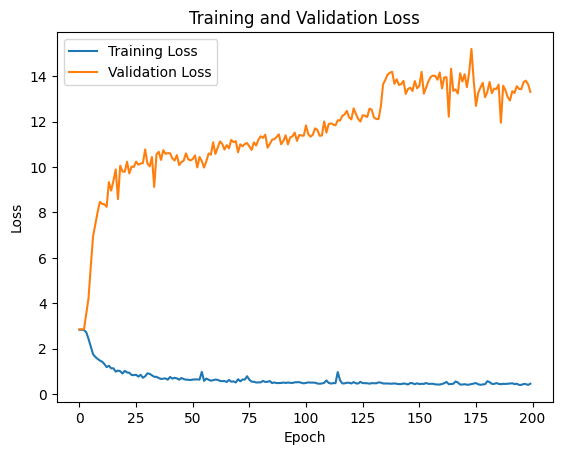

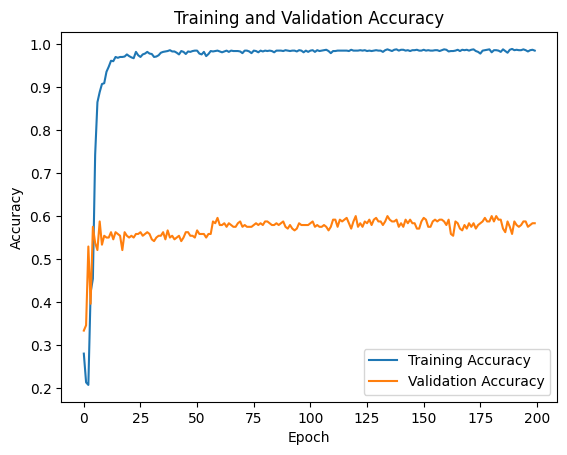

In [313]:
import matplotlib.pyplot as plt

def plot_loss(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def plot_accuracy(train_accuracies, val_accuracies):
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    # plt.ylim(0, 0.7)  # Set y-axis range for accuracy
    # plt.xticks(range(len(train_accuracies)), range(len(train_accuracies)))  # Set integer x-axis ticks
    plt.legend()
    plt.show()

# Assuming train_losses, train_accuracies, val_losses, val_accuracies are available
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)